In [1]:
import qiskit
from qiskit import *
from qiskit.compiler import assemble
from qiskit.visualization import plot_histogram


import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

In [2]:
shots = 4000
number = 4
equality = shots / np.power(2, number)

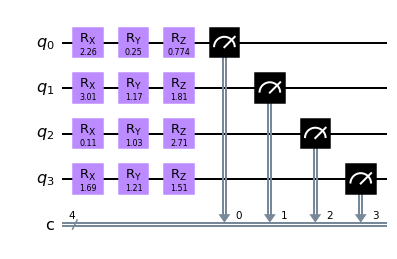

In [6]:
qc = QuantumCircuit(number, number)
rng = np.random.default_rng()

for j in range(number):
    qc.rx(rng.random() * np.pi, j)
    qc.ry(rng.random() * np.pi, j)
    qc.rz(rng.random() * np.pi, j)

qc.measure(range(number), range(number))
qc.draw("mpl")

In [7]:
circ = transpile(qc, backend)
qobj = assemble(circ, shots=shots)
result = backend.run(qobj).result()
result.get_counts()

{'0100': 29,
 '0110': 61,
 '1110': 75,
 '1000': 92,
 '1100': 17,
 '0101': 117,
 '0010': 181,
 '1101': 99,
 '0001': 379,
 '1011': 884,
 '0000': 96,
 '0011': 840,
 '0111': 238,
 '1111': 271,
 '1010': 206,
 '1001': 415}

In [21]:
rng.random()

0.16350938149669714

In [23]:
Dataset_size = 1000
backend = Aer.get_backend('qasm_simulator')

df = pd.DataFrame()

for k in tqdm(range(Dataset_size)):
    
    qc = QuantumCircuit(number, number)

    rng = np.random.default_rng()
    
    random_value = []

    for j in range(number):
        inside_random = [rng.random() * np.pi for _ in range(3)]
        qc.rx(inside_random[0], j)
        qc.ry(inside_random[1], j)
        qc.rz(inside_random[2], j)
        
        random_value = np.concatenate((random_value, inside_random))

    qc.measure(range(number), range(number))
    circ = transpile(qc, backend)

    qobj = assemble(circ, shots=shots)

    # Run and get counts
    result = backend.run(qobj).result()
    counts = result.get_counts()
    
    df_temp = pd.DataFrame(counts, index=[k])
    
    for i in range(number * 3):
        df_temp[f"target_{i}"] = [random_value[i]]
    
    df = df.append(df_temp)
    
    

100%|██████████| 1000/1000 [00:45<00:00, 21.83it/s]


In [24]:
copied_df = df.copy()

copied_df = (copied_df - copied_df.min()) / (copied_df.max() - copied_df.min())
# train_mean = copied_df.mean()
# train_std = copied_df.std()

# copied_df = (copied_df - train_mean) / train_std

# Replace all nan with 0
copied_df = copied_df.fillna(0)

copied_df.head()

,1011,1110,1101,1000,0001,1001,0111,0011,0000,0010,...,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11
0,0.000961,0.002265,0.129555,0.218598,0.237455,0.197526,0.001553,0.002393,0.291667,0.001864,...,0.475314,0.966755,0.945831,0.941584,0.460721,0.168283,0.144442,0.899786,0.559826,0.665039
1,0.082172,0.041903,0.213225,0.009250,0.061091,0.064246,0.380435,0.074591,0.009363,0.013514,...,0.619051,0.486394,0.754705,0.334033,0.228338,0.809954,0.646434,0.673262,0.525336,0.817392
2,0.321480,0.020385,0.008097,0.511685,0.003636,0.189545,0.000000,0.009972,0.009831,0.015843,...,0.504540,0.223357,0.578839,0.116517,0.132722,0.015001,0.747511,0.097591,0.953372,0.155589
3,0.281595,0.218573,0.036100,0.283836,0.000727,0.101357,0.001553,0.001197,0.002809,0.005126,...,0.061093,0.292566,0.707178,0.675163,0.312691,0.256630,0.788487,0.063160,0.986386,0.282096
4,0.009611,0.000000,0.000000,0.013145,0.203636,0.005986,0.018634,0.313921,0.475655,0.619292,...,0.864579,0.803408,0.434975,0.165125,0.892143,0.919759,0.177980,0.090424,0.041399,0.607219


In [25]:
# Check if there are any NaNs. 
copied_df.isnull().values.any()

False

In [26]:
batch_size = 1

target = copied_df.iloc[:, -3 * number:]
df = copied_df.iloc[:, :-3 * number]

# target = df.pop("target")
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

train_dataset = dataset.cache().shuffle(len(df)).batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [27]:
Dense = tf.keras.layers.Dense

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    Dense(3 * number, input_shape=(len(df.columns), ), activation=tf.nn.relu),
    Dense(1024, activation=tf.nn.relu),
    Dense(256, activation=tf.nn.relu),
    Dense(3 * number, activation=tf.nn.sigmoid)
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error")

model.fit(train_dataset, epochs=10,)

Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3339
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3339
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3339
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3339
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3339
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3339
Epoch 7/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3339
Epoch 8/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3339
Epoch 9/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3339
Epoch 10/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3339


In [28]:
value_this = np.rint(np.random.dirichlet(np.ones(16), size=1) * shots)
# value_this = np.reshape([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, shots], (1, 16))
new_val = (value_this - train_mean[:-3 * number].values) / train_std[:-3 * number].values

In [29]:
pred = model.predict(new_val)
pred = (pred * train_std[-3 * number:].values) + train_mean[-3 * number:].values
pred = np.squeeze(pred)

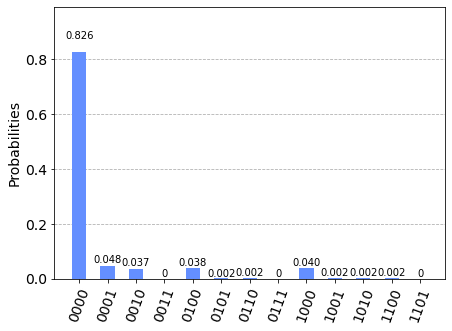

In [30]:
qc = QuantumCircuit(number, number)

for i in range(number):
    qc.rx(pred[0 * (i + 1)], i)
    qc.ry(pred[0 * (i + 2)], i)
    qc.rz(pred[0 * (i + 3)], i)

qc.measure(range(number), range(number))
circ = transpile(qc, backend)

qobj = assemble(circ, shots=shots)

# Run and get counts
result = backend.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [31]:
pred

array([2.83296618, 1.90737242, 2.58775395, 1.35554959, 2.69355289,
       1.28911482, 2.44718728, 2.01915576, 1.85118698, 2.35287576,
       1.72285063, 2.32537682])

In [32]:
names = ['{0:04b}'.format(i) for i in range(2 ** number)]
pred_df = pd.DataFrame(value_this, columns = names)

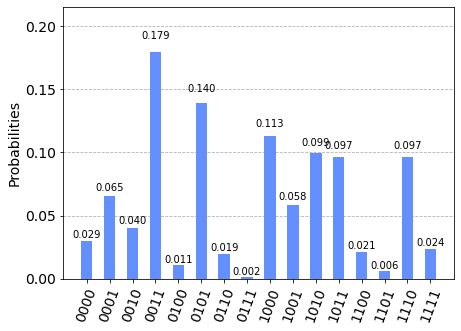

In [33]:
plot_histogram(pred_df.to_dict("records"))

In [141]:
diff = 0
value_this = np.squeeze(value_this)
for key, value in counts.items():
  diff += abs(value_this[int(key, 2)] - value)

print(diff)

3548.0


However as you can see, the result are not very beautiful. In fact, it's bad using this method of approximating results. 